In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/amazon-canada-products-2023-2-1m-products/amz_ca_total_products_data_processed.csv


Loading the Data

In [2]:
!pip install pyspark

from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("AmazonCanadaAnalysis").getOrCreate()

# Load the dataset
df = spark.read.csv('/kaggle/input/amazon-canada-products-2023-2-1m-products/amz_ca_total_products_data_processed.csv', header=True, inferSchema=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=8f76ef5f426d51d1848ac53dad48423b51c869d6dfecc89b9c479f97cf841903
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/27 01:14:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Data Exploration and Cleaning: Explore the data to understand its structure and clean it as necessary.



In [3]:
from pyspark.sql.functions import isnan, when, count, col
# Display the DataFrame schema
df.printSchema()

# Show summary statistics
df.describe().show()

# Check for missing values
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Drop duplicates and handle missing values as needed
df_cleaned = df.dropDuplicates().na.fill({"listPrice": 0}) # filling missing listPrice with 0

root
 |-- asin: string (nullable = true)
 |-- title: string (nullable = true)
 |-- imgUrl: string (nullable = true)
 |-- productURL: string (nullable = true)
 |-- stars: string (nullable = true)
 |-- reviews: string (nullable = true)
 |-- price: string (nullable = true)
 |-- listPrice: string (nullable = true)
 |-- categoryName: string (nullable = true)
 |-- isBestSeller: string (nullable = true)
 |-- boughtInLastMonth: string (nullable = true)



23/11/27 01:14:58 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+-----------------+-------------------+-----------------+--------------------+
|summary|                asin|               title|              imgUrl|           productURL|               stars|             reviews|               price|        listPrice|       categoryName|     isBestSeller|   boughtInLastMonth|
+-------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+-----------------+-------------------+-----------------+--------------------+
|  count|             2165926|             2165926|             2165924|              2165926|             2165925|             2165925|             2165926|          2165926|            2165926|          2165926|             2165913|
|   mean|2.3207400514224043E9|   2.862830523638E10| 4.759527

+----+-----+------+----------+-----+-------+-----+---------+------------+------------+-----------------+
|asin|title|imgUrl|productURL|stars|reviews|price|listPrice|categoryName|isBestSeller|boughtInLastMonth|
+----+-----+------+----------+-----+-------+-----+---------+------------+------------+-----------------+
|   0|    0|     2|         0|    1|      1|    0|        0|           0|           0|               13|
+----+-----+------+----------+-----+-------+-----+---------+------------+------------+-----------------+



Based on the output, it looks like most columns do not have missing values, which is good. However, there are a few columns with missing data that need to be addressed:

* imgUrl has 2 missing values.
* stars and reviews each have 1 missing value.
* boughtInLastMonth has 13 missing values.

Since the dataset it very larg I will just delete these records

In [4]:
df_cleaned = df.na.drop(subset=["imgUrl", "stars", "reviews", "boughtInLastMonth"])
# Check for missing values
df_cleaned.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+-----+------+----------+-----+-------+-----+---------+------------+------------+-----------------+
|asin|title|imgUrl|productURL|stars|reviews|price|listPrice|categoryName|isBestSeller|boughtInLastMonth|
+----+-----+------+----------+-----+-------+-----+---------+------------+------------+-----------------+
|   0|    0|     0|         0|    0|      0|    0|        0|           0|           0|                0|
+----+-----+------+----------+-----+-------+-----+---------+------------+------------+-----------------+



In [5]:
# Remove rows where 'price' is null or NaN
df_cleaned = df_cleaned.filter(~(isnan(col("price")) | col("price").isNull()))

# Data Analysis

In [6]:
from pyspark.sql.functions import col

# Convert isBestSeller to numerical value
df_cleaned = df_cleaned.withColumn("isBestSeller", col("isBestSeller").cast("integer"))
# Ensure that 'stars' and 'price' are of a numerical type
df_cleaned = df_cleaned.withColumn("stars", col("stars").cast("float"))
df_cleaned = df_cleaned.withColumn("price", col("price").cast("float"))
df_cleaned = df_cleaned.withColumn("reviews", col("reviews").cast("float"))

# Calculate correlations
print("Correlation between stars and price:", df_cleaned.stat.corr("stars", "price"))
print("Correlation between reviews and price:", df_cleaned.stat.corr("reviews", "price"))
print("Correlation between stars and isBestSeller:", df_cleaned.stat.corr("stars", "isBestSeller"))
print("Correlation between reviews and isBestSeller:", df_cleaned.stat.corr("reviews", "isBestSeller"))


Correlation between stars and price: 0.9923098616539626


Correlation between reviews and price: 0.9940433778168181


Correlation between stars and isBestSeller: 0.00014394855188372708


Correlation between reviews and isBestSeller: -1.9018417641302189e-06


In [7]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

df_cleaned = df_cleaned.filter(~(isnan(col("price")) | col("price").isNull()))

# Assemble features with handling invalid (null) values by skipping them
assembler = VectorAssembler(inputCols=["stars", "reviews"], outputCol="features", handleInvalid="skip")
df_features = assembler.transform(df_cleaned)
# Split the data into training and test sets
train_data, test_data = df_features.randomSplit([0.7, 0.3])
train_data = train_data.filter(~isnan(col('price')) & ~col('price').isNull())
test_data = test_data.filter(~isnan(col('price')) & ~col('price').isNull())
# Train the model
lr = LinearRegression(featuresCol='features', labelCol='price')
lr_model = lr.fit(train_data)

# Make predictions
predictions = lr_model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data =", rmse)

23/11/27 01:17:21 WARN Instrumentation: [db20bc3c] regParam is zero, which might cause numerical instability and overfitting.
23/11/27 01:17:35 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/11/27 01:17:43 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Root Mean Squared Error (RMSE) on test data = 3479.509219894769


# visualization 

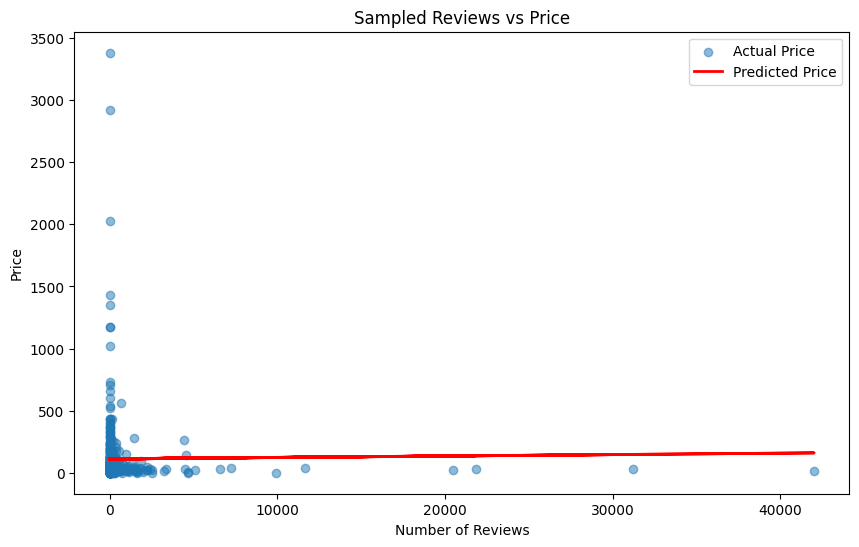

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample 0.1% of the data randomly without replacement
sampled_predictions = predictions.sample(False, 0.001)

# Convert to Pandas DataFrame
result_pdf = sampled_predictions.select("reviews", "price", "prediction").toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(result_pdf['reviews'], result_pdf['price'], alpha=0.5, label='Actual Price')
plt.plot(result_pdf['reviews'], result_pdf['prediction'], color='red', linewidth=2, label='Predicted Price')
plt.xlabel('Number of Reviews')
plt.ylabel('Price')
plt.title('Sampled Reviews vs Price')
plt.legend()
plt.show()

23/11/27 01:18:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/27 01:18:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/27 01:18:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/27 01:18:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/27 01:18:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/27 01:18:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/27 01:18:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/27 01:18:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


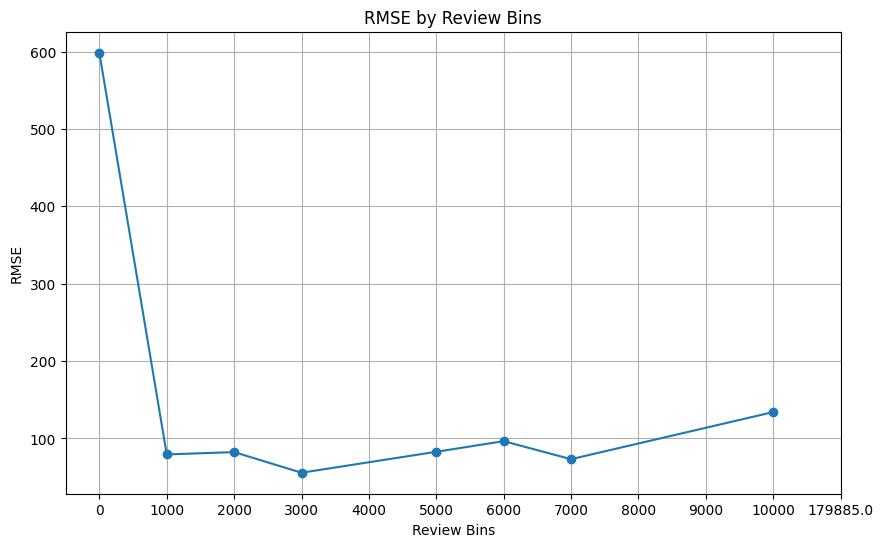

In [9]:
from pyspark.sql.functions import col, sqrt, avg
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import Bucketizer

# Define the evaluator
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")

# Sample 0.1% of the data randomly without replacement
sampled_predictions = predictions.sample(False, 0.001)

# Find the maximum value in the 'reviews' column
max_reviews = sampled_predictions.agg({"reviews": "max"}).collect()[0][0]

# Define the bins, making sure the last bin covers the maximum value
bins = [0, 1000, 2000, 3000, 4000, 5000, 6000,7000,8000,9000,10000, max_reviews]

# Create the bucketizer
bucketizer = Bucketizer(splits=bins, inputCol="reviews", outputCol="review_bins")

# Apply the bucketizer to create the bins
predictions_binned = bucketizer.transform(sampled_predictions)


# Group by the review_bins and calculate RMSE for each bin
rmse_by_bin = (
    predictions_binned
    .groupBy("review_bins")
    .agg(
        sqrt(avg((col("price") - col("prediction"))**2)).alias("rmse")
    )
    .orderBy("review_bins")
)

# Collect the data and plot
rmse_by_bin_data = rmse_by_bin.toPandas()

plt.figure(figsize=(10, 6))
plt.plot(rmse_by_bin_data['review_bins'], rmse_by_bin_data['rmse'], marker='o')
plt.xlabel('Review Bins')
plt.ylabel('RMSE')
plt.title('RMSE by Review Bins')
plt.xticks(ticks=range(len(bins)), labels=bins)
plt.grid(True)
plt.show()

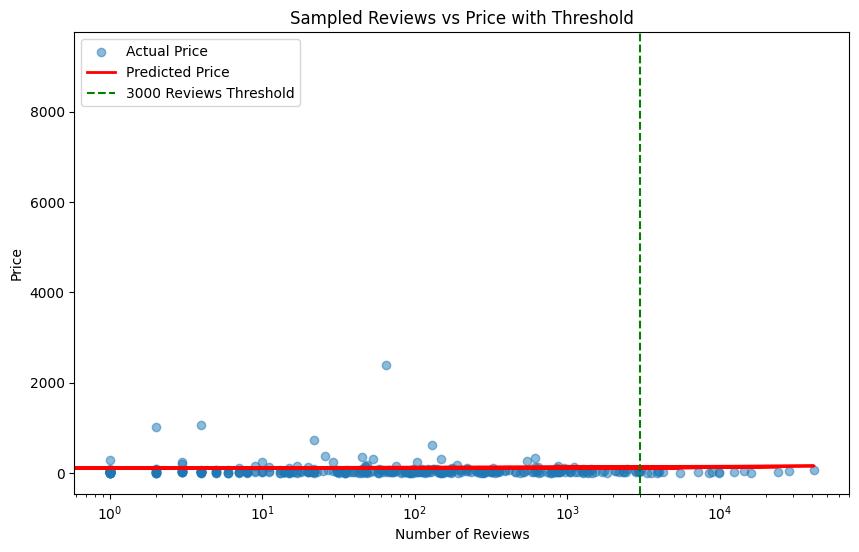

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample 0.1% of the data randomly without replacement
sampled_predictions = predictions.sample(False, 0.001)

# Convert to Pandas DataFrame
result_pdf = sampled_predictions.select("reviews", "price", "prediction").toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(result_pdf['reviews'], result_pdf['price'], alpha=0.5, label='Actual Price')
plt.plot(result_pdf['reviews'], result_pdf['prediction'], color='red', linewidth=2, label='Predicted Price')
plt.axvline(x=3000, color='green', linestyle='--', label='3000 Reviews Threshold')
plt.xlabel('Number of Reviews')
plt.ylabel('Price')
plt.title('Sampled Reviews vs Price with Threshold')
plt.legend()
plt.xscale('log')  # Optional: Use logarithmic scale if the reviews vary by orders of magnitude
plt.show()

In [11]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Split the data
above_3000_df = predictions.filter(col("reviews") > 3000).drop('prediction')
below_3000_df = predictions.filter(col("reviews") <= 3000).drop('prediction')

# Train a new model on data with more than 3000 reviews
lr_above_3000 = LinearRegression(featuresCol='features', labelCol='price')
lr_model_above_3000 = lr_above_3000.fit(above_3000_df)

# Train a new model on data with less than or equal to 3000 reviews
lr_below_3000 = LinearRegression(featuresCol='features', labelCol='price')
lr_model_below_3000 = lr_below_3000.fit(below_3000_df)

# Evaluate the models
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")

# Make predictions and evaluate the new models
above_3000_predictions = lr_model_above_3000.transform(above_3000_df)
above_3000_rmse = evaluator.evaluate(above_3000_predictions)

below_3000_predictions = lr_model_below_3000.transform(below_3000_df)
below_3000_rmse = evaluator.evaluate(below_3000_predictions)

# Compare the models
print(f"Above 3000 reviews model RMSE: {above_3000_rmse}")
print(f"Below 3000 reviews model RMSE: {below_3000_rmse}")

23/11/27 01:19:20 WARN Instrumentation: [c25f3d54] regParam is zero, which might cause numerical instability and overfitting.
23/11/27 01:19:49 WARN Instrumentation: [7aafec45] regParam is zero, which might cause numerical instability and overfitting.


Above 3000 reviews model RMSE: 16153.63865360782
Below 3000 reviews model RMSE: 506.5202428550075
